# Dataset과 Dataloader
* 데이터 샘플을 처리하는 코드는 지저분하고 유지보수가 어려울 수 있다.
* 더 나은 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적이다.
* PyTorch는 <code>torch.utils.data.DataLoader</code>와 <code>torch.utils.data.Dataset</code>의 두 가지 데이터 기본 요소를 제공하여 미리 준비해둔(pre-loaded) 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 한다. 
* <code>Dataset</code>은 Sample과 Label을 저장하고, <code>DataLoader</code>는 <code>Dataset</code>을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다.
* PyTorch의 도메인 특화 라이브러리들은 (FashionMNIST와 같은) 미리 준비해둔(pre-loaded) 다양한 데이터셋을 제공한다.
* 이러한 데이터셋은 모델을 만들어보고 프로토타입의 성능을 측정(benchmark)하는데 사용할 수 있다.

# 데이터셋 불러오기
* <code>TorchVision</code>에서 FashionMNIST 데이터셋을 불러오는 예제
* <code>root</code>는 학습/테스트 데이터가 저장되는 경로입니다.
* <code>train</code>은 학습용 or 테스트용 데이터셋 여부를 지정한다.
* <code>download=True</code>는 <code>root</code>에 데이터가 없는 경우 인터넷에서 다운로드 한다.
* <code>transform</code>과 <code>target_transform</code>은 feature와 label, transform을 지정한다.

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(root='data',
                                     train=True,
                                     download=True,
                                     transform=ToTensor()
                                     )

test_data = datasets.FashionMNIST(root='data',
                                 train=False,
                                 download=True,
                                 transform=ToTensor()
                                 )

# 데이터셋을 순회하고 시각화하기
* <code>Dataset</code>에 리스트처럼 직접 접근(index)할 수 있습니다.
    * <code>training_data[index]</code>
* <code>matplotlib</code>을 사용하여 학습 데이터의 일부를 시각화해보자.

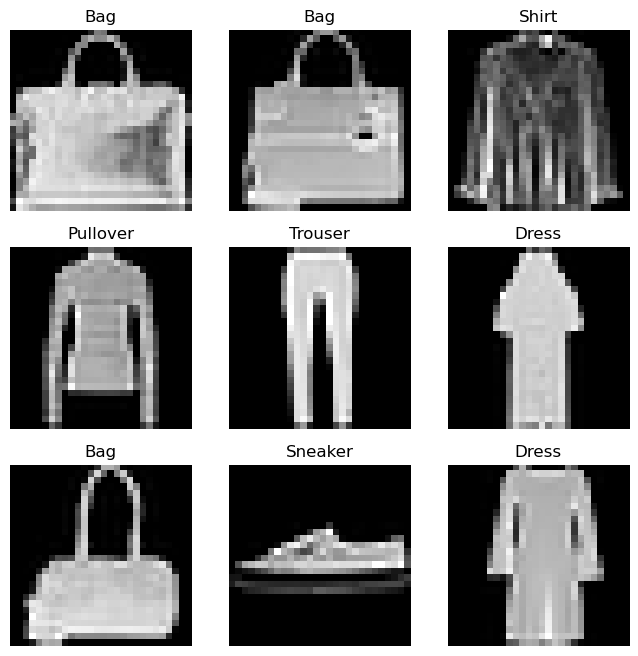

In [7]:
import matplotlib.pyplot as plt

labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1, )).item()
    img, label = training_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')

plt.show()

# 파일에서 사용자 정의 데이터셋 만들기
* 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 한다.
## <code>\_\_init\_\_</code>
* <code>\_\_init\_\_</code> 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행된다. 여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 두가지 transform을 초기화합니다.
## <code>\_\_len\_\_</code>
* <code>\_\_len\_\_</code> 함수는 데이터셋의 샘플 개수를 반환한다.
## <code>\_\_getitem\_\_</code>
* <code>\_\_getitem\_\_</code> 함수는 주어진 인덱스 <code>idx</code>에 해당하는 샘플을 데이터셋에서 불러오고 반환한다. 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, <code>read_image</code>를 사용하여 이미지를 텐서로 변환하고, <code>self.img_labels</code>의 csv 데이터로부터 해당하는 label을 가져오고, (해당하는 경우) transform 함수들을 호출한 뒤, 텐서 이미지와 label을 Python Dictionary type으로 반환한다.

In [8]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotation_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_tranfrom = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_lables.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        if self.target_tarnsform:
            label = self.target_tarnsform(label)
        return image, label

# DataLoader로 학습용 데이터 준비하기
* <code>Dataset</code>은 데이터셋의 feature를 가져오고 하나의 샘플에 label을 지정하는 일을 한 번에 한다. 모델을 학습할 때, 일반적으로 샘플들을 mini-batch로 전달하고, 매 epoch마다 데이터를 다시 섞어서 overfitting을 막고, Python의 <b>multiprocessing</b>을 사용하여 데이터 검색 속도를 높인다.

<code>DataLoader</code>는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 iterable 객체이다.

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# DataLoader를 통해 순회하기 (iterate)
* <code>DataLoader</code>에 데이터셋을 불러온 뒤에 필요에 따라 데이터셋을 순회할 수 있습니다. 아래의 각 순회(iteration)는 (각각 <code>batch_size=64</code>의 feature와 label을 포함하는) <code>train_features</code>와 <code>train_labels</code>의 batch를 반환합니다. <code>shuffle=True</code>로 지정했으므로, 모든 batch 순회한 뒤 데이터가 섞입니다. (데이터 불러오기 순서를 보다 세밀하게 제어하려면 Samplers를 알아보자.)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Label: 9, Name: Ankle Boot


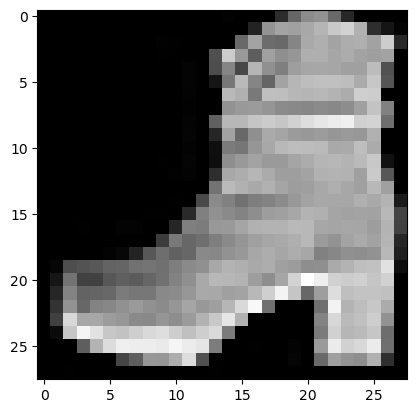

In [15]:
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].squeeze()
label = train_labels[0]
print(f'Label: {label}, Name: {labels_map[label.item()]}')
plt.imshow(img, cmap='gray')
plt.show()